<a href="https://colab.research.google.com/github/jdasam/ant5015/blob/2024F/notebooks/3rd_week_note_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
from pathlib import Path

import torch
import torchaudio

In [2]:
'''
Let's only use testset
'''
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
# !는 주피터에서 터미널 명령어를 사용할때 붙임
# python이 아닌 OS (Linux)에 명령을 내리고 싶을 때 실행


--2024-09-23 09:33:21--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 172.253.117.207, 142.250.99.207, 74.125.20.207, ...
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|172.253.117.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz’

nsynth-test.jsonwav 100%[===================>] 333.31M  73.9MB/s    in 4.5s    

2024-09-23 09:33:26 (73.9 MB/s) - ‘nsynth-test.jsonwav.tar.gz’ saved [349501546/349501546]



In [4]:
# 압축 풀기
!tar -xf nsynth-test.jsonwav.tar.gz

In [10]:
json_fn = '/content/nsynth-test/examples.json'

with open(json_fn, 'r') as f:
  metadata = json.load(f)

type(metadata)
# , metadata.keys()
metadata['mallet_acoustic_047-106-127']

{'qualities': [0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
 'pitch': 106,
 'note': 174786,
 'instrument_source_str': 'acoustic',
 'velocity': 127,
 'instrument_str': 'mallet_acoustic_047',
 'instrument': 488,
 'sample_rate': 16000,
 'qualities_str': ['fast_decay', 'percussive', 'reverb'],
 'instrument_source': 0,
 'note_str': 'mallet_acoustic_047-106-127',
 'instrument_family': 5,
 'instrument_family_str': 'mallet'}

In [23]:
# list all wav files in dataset
from pathlib import Path
dir = Path('/content/nsynth-test/audio')

dir.exists() # check file or directory exist
# dir.is_file()

# list all wav files in the dir
wav_fns = dir.glob('*.wav')

# for wav in wav_fns:
#   print(wav)

# generator does not save actual list
# print('second loop')
# for wav in wav_fns:
#   print(wav)

wav_fns = list(dir.glob('*.wav'))
wav_fns.sort()
len(wav_fns), len(metadata)
wav_fns[:10]

[PosixPath('/content/nsynth-test/audio/bass_electronic_018-022-100.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-023-025.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-023-075.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-023-127.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-024-025.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-024-100.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-026-025.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-026-075.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-026-127.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-027-075.wav')]

In [27]:
wav_fns[0].name, wav_fns[0].stem, wav_fns[0].with_suffix('.pt')

('bass_electronic_018-022-100.wav',
 'bass_electronic_018-022-100',
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-022-100.pt'))

In [28]:
for wav_fn in wav_fns:
  stem = wav_fn.stem
  assert stem in metadata, 'Stem is not in metadata'



In [46]:
import IPython.display as ipd

idx = 1000
wav_fn = wav_fns[idx]

audio_sample, sr = torchaudio.load(wav_fn)
print(audio_sample.shape, sr)

ipd.Audio(audio_sample, rate=sr)

torch.Size([1, 64000]) 16000


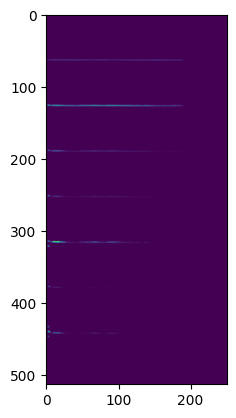

In [47]:
# spectrogram

spec_converter = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=256)
spec = spec_converter(audio_sample)[0] # select 0th item for 0th dim
spec.shape

import matplotlib.pyplot as plt
plt.imshow(spec)

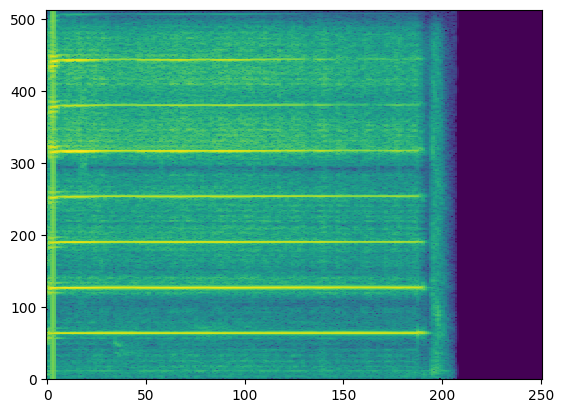

In [48]:
db_converter = torchaudio.transforms.AmplitudeToDB()
db_spec = db_converter(spec)
plt.imshow(db_spec, origin='lower', aspect='auto', interpolation='none')

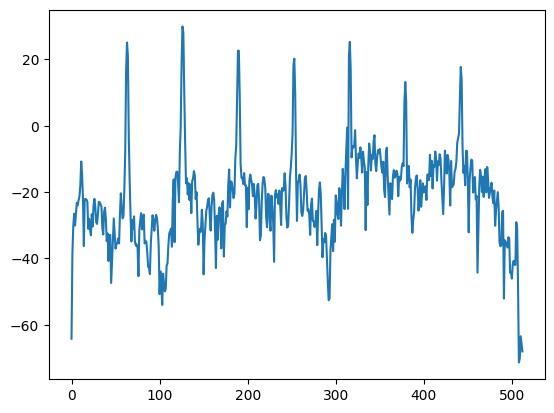

In [51]:
spectrum = db_spec[:, 50]
spectrum.shape
plt.plot(spectrum)

## Make sine wave
- 1 period of angle = 2 * pi
- 220 period of angle = 2 * pi * 220 / sec

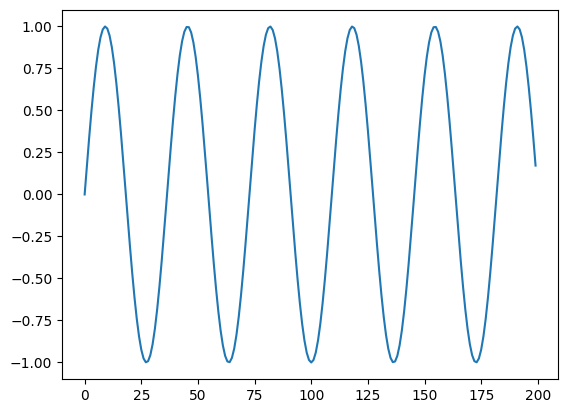

In [58]:
from math import pi
torch.set_printoptions(sci_mode=False)
def make_sine_wav(freq, dur, amp, sr):
  # how many samples do we need?
  num_samples = dur * sr
  output = torch.arange(num_samples)
  # convert to elapsed time in seconds
  output = output / sr # elapsed_time
  # distance = time * speed
  # speed in radian = 2 pi * cycle
  radian_speed = 2 * pi * freq
  output = output * radian_speed # accumulated angle
  output = torch.sin(output) # put it into sin function

  return output

sin = make_sine_wav(freq=440, dur=3, amp=0.5, sr=16000)
ipd.display(ipd.Audio(sin, rate=sr))
plt.plot(sin[:200])

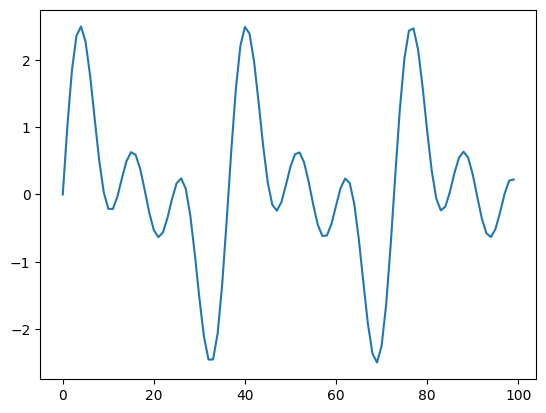

In [60]:
sin = make_sine_wav(freq=440, dur=3, amp=0.5, sr=16000)
sin2 = make_sine_wav(freq=880, dur=3, amp=0.2, sr=16000)
sin3 = make_sine_wav(freq=1320, dur=3, amp=0.05, sr=16000)

merged_sin = sin + sin2 + sin3
ipd.display(ipd.Audio(merged_sin, rate=sr))
plt.plot(merged_sin[:100])

In [61]:
sin = make_sine_wav(freq=440, dur=4, amp=0.5, sr=16000)
audio_with_sin = audio_sample + sin

ipd.Audio(audio_with_sin, rate=sr)

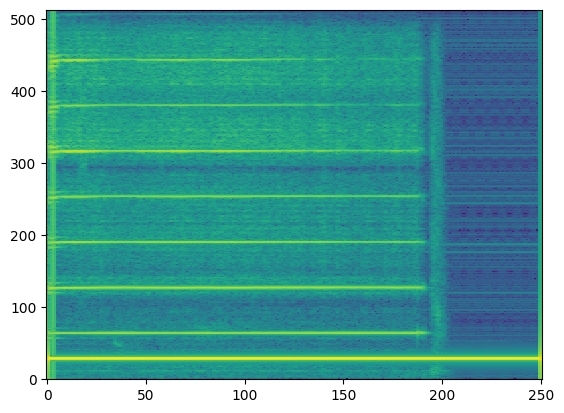

In [63]:
spec = spec_converter(audio_with_sin)
db_spec = db_converter(spec)[0]

plt.imshow(db_spec, origin='lower', aspect='auto', interpolation='none')

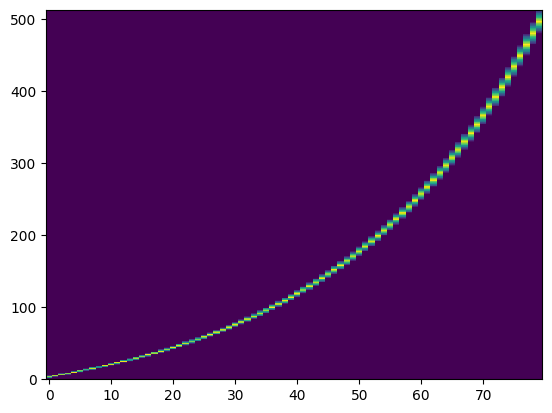

In [69]:
mel_fb = torchaudio.transforms.MelScale(n_mels=80, n_stft=513, sample_rate=sr, f_min=20)
plt.imshow(mel_fb.fb, origin='lower', aspect='auto', interpolation='none')

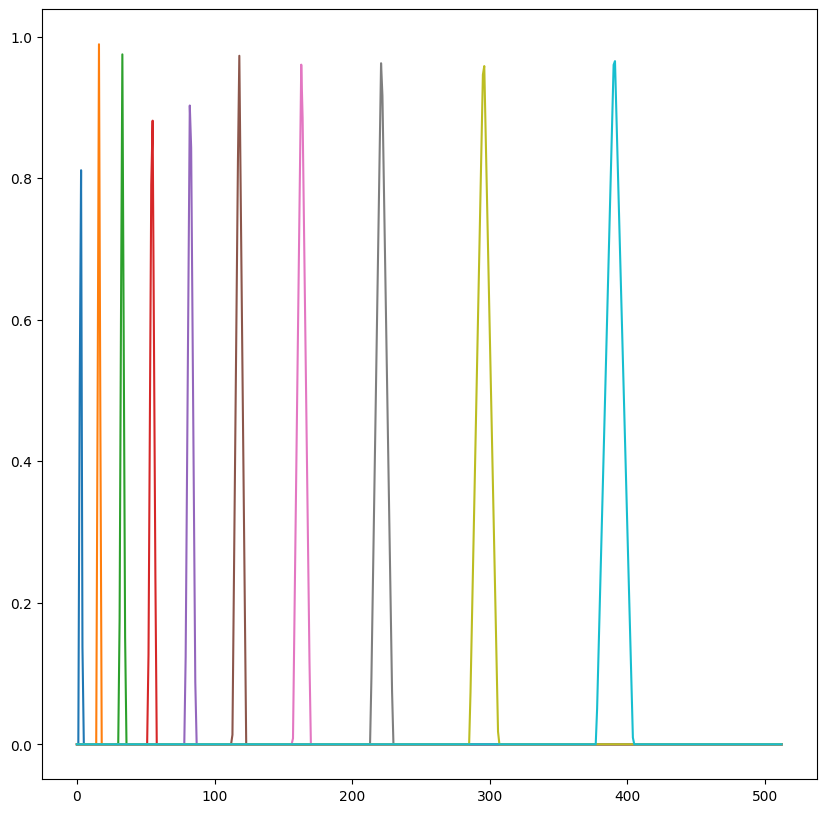

In [70]:
plt.figure(figsize=(10,10))

for i in range(0, 80, 8):
  plt.plot(mel_fb.fb[:, i])

torch.Size([1, 80, 251])


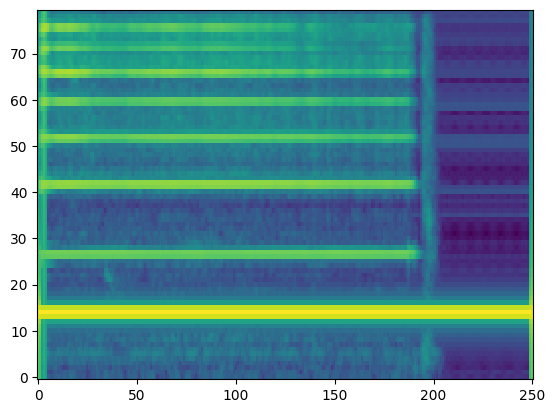

In [74]:
mel_spec = mel_fb(spec)
print(mel_spec.shape)
db_spec = db_converter(mel_spec)[0]
plt.imshow(db_spec, origin='lower', aspect='auto', interpolation='none')

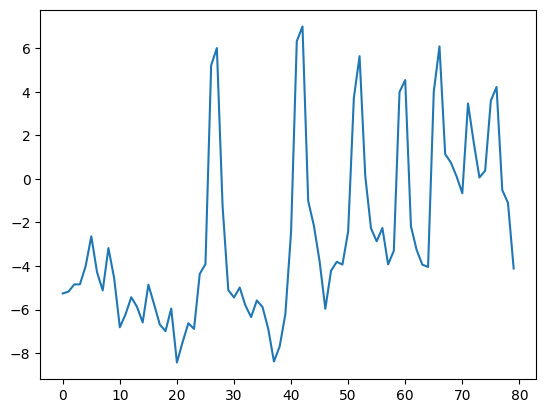

In [80]:
mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                                     n_fft=1024,
                                                     hop_length=256,
                                                     f_min=20,
                                                     n_mels=80)
mel_spec = mel_converter(audio_sample[0])
mel_spectrum = mel_spec[:, 30]
plt.plot(mel_spectrum.log())

In [84]:
from tqdm.auto import tqdm
import random
# Load all audio samples and get label

wav_fns.sort()
random.seed(0)
random.shuffle(wav_fns)

spectrums = []
labels = []

for wav_fn in tqdm(wav_fns):
  audio_sample, sr = torchaudio.load(wav_fn)
  db_spectrum = db_converter(mel_converter(audio_sample))[0, :, 30] # 0th channel, every mel bin, 30th time frame
  spectrums.append(db_spectrum)
  pitch = metadata[wav_fn.stem]['pitch'] % 12 # only consider pitch class, ignore octave
  labels.append(pitch)


  0%|          | 0/4096 [00:00<?, ?it/s]

In [96]:
# convert every data sample to torch.tensor
training_data = spectrums[:-100]
training_data = torch.stack(training_data) / 100
training_data.shape,

(torch.Size([3996, 80]),)

In [97]:
training_data.min(), training_data.max()

(tensor(-1.), tensor(0.4712))

In [87]:
training_labels = labels[:-100]
training_labels = torch.tensor(training_labels)
training_labels

tensor([11,  6,  8,  ...,  0, 10, 11])

In [91]:
import torch.nn as nn

classifier = nn.Linear(in_features=80, out_features=12)
classifier.weight.shape

torch.Size([12, 80])

In [100]:
logit = classifier(training_data)
# logit.shape
logit[300] # logit of 300th sample

tensor([ 0.1053,  0.0812, -0.1891, -0.0993,  0.0593, -0.0957,  0.2244,  0.2184,
        -0.0978, -0.0442, -0.1376, -0.0713], grad_fn=<SelectBackward0>)

In [103]:
torch.softmax(logit[300], dim=-1)

tensor([0.0921, 0.0899, 0.0686, 0.0751, 0.0880, 0.0753, 0.1038, 0.1032, 0.0752,
        0.0793, 0.0723, 0.0772], grad_fn=<SoftmaxBackward0>)

In [110]:
def softmax(x, dim=-1):
  exp_x = torch.exp(x)
  sum_exp_x = exp_x.sum(dim=dim, keepdim=True)
  return exp_x / sum_exp_x
  print(exp_x)

softmax(logit[300])

tensor([0.0921, 0.0899, 0.0686, 0.0751, 0.0880, 0.0753, 0.1038, 0.1032, 0.0752,
        0.0793, 0.0723, 0.0772], grad_fn=<DivBackward0>)

In [109]:
logit_sum = logit.sum(dim=-1)
print(logit_sum.shape)
logit_sum = logit.sum(dim=-1, keepdim=True)
print(logit_sum.shape)

torch.Size([3996])
torch.Size([3996, 1])
